# Will it snow at the ESE 2024 Kongress?  

Copyright 2024 by [Doulos](https://www.doulos.com)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at:\
http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/doulos/ESE24-edgeAI/blob/main/5_TFU_perf.ipynb)

## Part5- Verifying the Performance of the Quantized Model

In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    # on colab
    !wget https://github.com/Doulos/ESE24-edgeAI/raw/refs/heads/main/dataset/x_test.parquet
    !wget https://github.com/Doulos/ESE24-edgeAI/raw/refs/heads/main/dataset/y_test.parquet
    !wget https://github.com/Doulos/ESE24-edgeAI/raw/refs/heads/main/assets/model.tar.gz
    !tar -xzvf /content/model.tar.gz
    path = path_output = "/content"
    path_model = os.path.join(path, "model")

else:
    # elsewhere, assume artefacts are in dataset/ relative to this notebook
    path="dataset"
    path_model="model"
    path_output= ""

### Read test data

In [1]:
import polars as pl
import os 

x_test = pl.read_parquet(os.path.join(path,"x_test.parquet"))
y_test = pl.read_parquet(os.path.join(path,"y_test.parquet"))

We load the layers from the disk, then recreate the corresponding model.

In [2]:
import tensorflow.keras as keras

layer = keras.layers.TFSMLayer(os.path.join(path_model,"snow_forecast"))
input_layer = keras.Input(shape=(6,))
output_layer = layer(input_layer)
model = keras.Model(input_layer, output_layer)

### Load the Quantized TF lite model

In [3]:
import tensorflow as tf
import pprint

In [4]:
interpreter = tf.lite.Interpreter(model_path=os.path.join(path_model,"snow_model_quantized.tflite"))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

Get information about input and output tensor:

In [5]:
print("input_details = ")
pprint.pp(input_details)
print("\noutput details = ")
pprint.pp(output_details)

input_details = 
{'name': 'serving_default_keras_tensor:0',
 'index': 0,
 'shape': array([1, 6], dtype=int32),
 'shape_signature': array([-1,  6], dtype=int32),
 'dtype': <class 'numpy.int8'>,
 'quantization': (0.024246428161859512, 2),
 'quantization_parameters': {'scales': array([0.02424643], dtype=float32),
                             'zero_points': array([2], dtype=int32),
                             'quantized_dimension': 0},
 'sparsity_parameters': {}}

output details = 
{'name': 'StatefulPartitionedCall_1:0',
 'index': 7,
 'shape': array([1, 1], dtype=int32),
 'shape_signature': array([-1,  1], dtype=int32),
 'dtype': <class 'numpy.int8'>,
 'quantization': (0.00390625, -128),
 'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
                             'zero_points': array([-128], dtype=int32),
                             'quantized_dimension': 0},
 'sparsity_parameters': {}}


### Exercise one prediction
- We must quantized the input (because the quantized model is expecting int8)
- We perform the inference
- We convert back the predicted output (int8) to a float

In [6]:
x_test[0]

t0,t1,t2,h0,h1,h2
f64,f64,f64,f64,f64,f64
-1.88359,-1.920422,-1.969532,0.501863,0.501863,0.676021


In [7]:
in_scale, in_zero = input_details["quantization"]
xt = (x_test[0]/in_scale + in_zero).cast(pl.Int8)
xt

t0,t1,t2,h0,h1,h2
i8,i8,i8,i8,i8,i8
-75,-77,-79,22,22,29


In [8]:
interpreter.set_tensor(input_details["index"], xt)
interpreter.invoke()
pred = interpreter.get_tensor(output_details["index"])[0]
pred

array([115], dtype=int8)

In [9]:
out_scale, out_zero = output_details["quantization"]
(float(pred[0])-out_zero)*out_scale

0.94921875

**Note** We can save the rescaling from int to float for the output *for his particular model*.\
Indeed, for have a binary classification, with 0.5 being the threshold which corresponds to 0 in the quantized model.

In [10]:
for v in [0,0.5,1]:
    print(f"pred(float)={v:3.1f} -> pred(int)={int(v/out_scale+out_zero):>5}")

pred(float)=0.0 -> pred(int)= -128
pred(float)=0.5 -> pred(int)=    0
pred(float)=1.0 -> pred(int)=  128


### Compute predictions for each model on the test data

#### full-blow model:

In [11]:
y_test_pred = model.predict(x_test)
y_test_pred = (y_test_pred > 0.5).astype("int32")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### quantized model:

In [12]:
import numpy as np
def predict(x):
    xt = (x/in_scale + in_zero).cast(pl.Int8)
    interpreter.set_tensor(input_details["index"], xt)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details["index"])[0]
    return pred[0]>0

In [13]:
y_test_quant = np.zeros((x_test.shape[0],), dtype=int)
for i in range(x_test.shape[0]):
    y_test_quant[i] = int(predict(x_test[i]))

### Compare performance full-blown vs quantized model

#### Helpers functions

In [14]:
import sklearn.metrics
import matplotlib.pyplot as plt

def show_confusion_matrix(cm, model_name="Confusion Matrix"):
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Samples')
    plt.title(model_name)
    plt.xticks(ticks=[0, 1], labels=['Predicted "No Snow"', ' Predicted "Snow"'])
    plt.yticks(ticks=[0, 1], labels=["It's not snowing!", "It's snowing!"])
    plt.text(0,0,f"{cm[0][0]} (TN)", fontsize=12, color='white', ha='center')
    plt.text(1,0,f"{cm[0][1]} (FP)", fontsize=12, color='black', ha='center')
    plt.text(0,1,f"{cm[1][0]} (FN)", fontsize=12, color='black', ha='center')
    plt.text(1,1,f"{cm[1][1]} (TP)", fontsize=12, color='white', ha='center')
    plt.show()
    
def get_model_performance(model_name, y_test, y_test_pred, show_cm=True):
    cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    if (show_cm):
        show_confusion_matrix(cm, model_name)
    
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    accuracy  = (TP + TN) / (TP + TN + FN + FP)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2 * recall * precision) / (recall + precision)
    return (accuracy, recall, precision, f1_score)

#### Show performance results

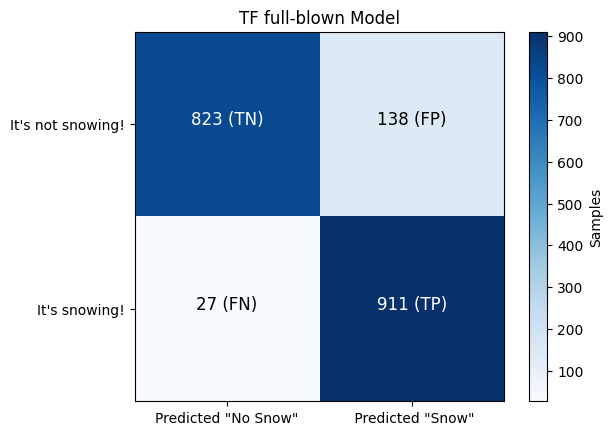

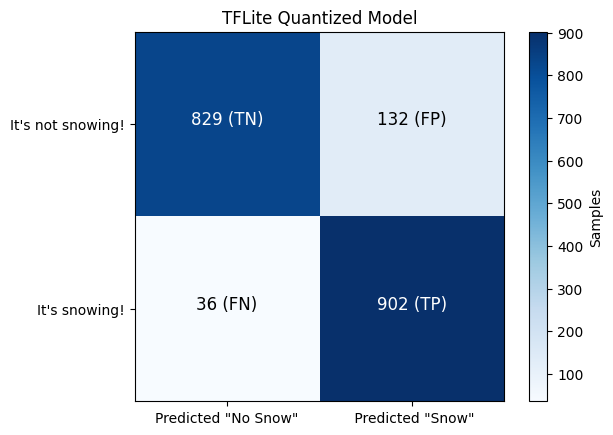


MODELS COMPARISON

           :  ORIG   :  QUANT  :
-----------+---------+---------+
Accuracy   :  0.913  :  0.912  :
Recall     :  0.971  :  0.962  :
Precision  :  0.868  :  0.872  :
F1-score   :  0.917  :  0.915  :


In [15]:
full_perf = get_model_performance("TF full-blown Model", y_test, y_test_pred)
quant_perf = get_model_performance("TFLite Quantized Model", y_test, y_test_quant)

metrics_name = ['Accuracy', 'Recall', 'Precision', 'F1-score']
print("\nMODELS COMPARISON\n")
print("           :  ORIG   :  QUANT  :")
print("-----------+---------+---------+")
for m,orig,quant in zip(metrics_name, full_perf, quant_perf):
    print(f"{m:10} : {orig:^7.3f} : {quant:^7.3f} :")